In [2]:
import pandas as pd
import os
import shutil
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import soundfile
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Lambda, Reshape

# Preparing data

In [3]:
# Clearing metadata
metadata_path = 'archive\\metadata.csv'
md = pd.read_csv(metadata_path)
metadata = md[['id', 'name','filename']]

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5422 non-null   int64 
 1   name      5422 non-null   object
 2   filename  5422 non-null   object
dtypes: int64(1), object(2)
memory usage: 127.2+ KB


In [4]:
# Crosschecking files with csv
# A lot of files are unlabeled - its important too making sets only with labeled data
csv_filenames = metadata['filename'].tolist()

for filename in os.listdir('archive\\wavfiles'):
    if filename not in csv_filenames:
        print(f"File {filename} is not in csv.")

File 101308-0.wav is not in csv.
File 101308-1.wav is not in csv.
File 101308-10.wav is not in csv.
File 101308-11.wav is not in csv.
File 101308-12.wav is not in csv.
File 101308-13.wav is not in csv.
File 101308-2.wav is not in csv.
File 101308-3.wav is not in csv.
File 101308-4.wav is not in csv.
File 101308-5.wav is not in csv.
File 101308-6.wav is not in csv.
File 101308-7.wav is not in csv.
File 101308-8.wav is not in csv.
File 101308-9.wav is not in csv.
File 101427-0.wav is not in csv.
File 101427-1.wav is not in csv.
File 101427-10.wav is not in csv.
File 101427-11.wav is not in csv.
File 101427-2.wav is not in csv.
File 101427-3.wav is not in csv.
File 101427-4.wav is not in csv.
File 101427-5.wav is not in csv.
File 101427-6.wav is not in csv.
File 101427-7.wav is not in csv.
File 101427-8.wav is not in csv.
File 101427-9.wav is not in csv.
File 104527-0.wav is not in csv.
File 104527-1.wav is not in csv.
File 104527-10.wav is not in csv.
File 104527-11.wav is not in csv.
Fi

In [5]:
# Checking bird names
names = metadata["name"].unique()
names

array(["Bewick's Wren", 'Northern Mockingbird', 'American Robin',
       'Song Sparrow', 'Northern Cardinal'], dtype=object)

In [6]:
metadata["name"].value_counts()

name
Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: count, dtype: int64

In [21]:
# Moving files to according folders
for index, row in metadata.iterrows():
    if row['name'] == "Song Sparrow":
        shutil.move(os.path.join('archive\\wavfiles', row['filename']), os.path.join('archive\\sparrow', row['filename']))
    else:
        shutil.move(os.path.join('archive\\wavfiles', row['filename']), os.path.join('archive\\other', row['filename']))

In [10]:
# Converting to 16-bit and moving to data folder
for file in os.listdir('archive\\sparrow'):
    data, samplerate = soundfile.read(os.path.join('archive\\sparrow', file))
    soundfile.write(os.path.join('data\\sparrow', file), data, samplerate, subtype='PCM_16')

for file in os.listdir('archive\\other'):
    data, samplerate = soundfile.read(os.path.join('archive\\other', file))
    soundfile.write(os.path.join('data\\other', file), data, samplerate, subtype='PCM_16')

In [7]:
# Loading files 16khz, mono
def load_wav_16k_mono(filename):
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True) 
    return wav

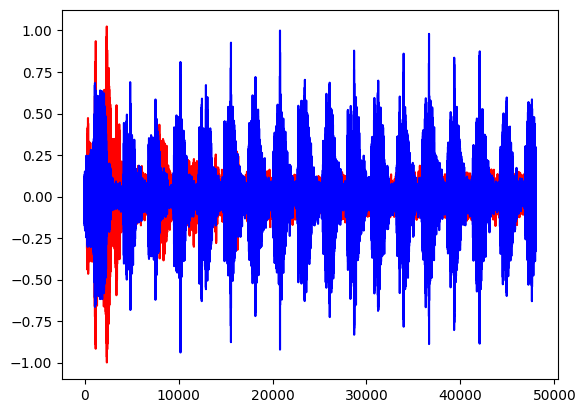

In [8]:
# Testing decode function
sparrow_wav = load_wav_16k_mono('data\\sparrow\\62782-7.wav')
other_wav   = load_wav_16k_mono('data\\other\\11846-6.wav')
plt.plot(sparrow_wav,'r')
plt.plot(other_wav, 'b')
plt.show()

# Creating dataset

In [9]:
# Creating labeled dataset
sparrow_path = os.path.join('data', 'sparrow')
other_path = os.path.join('data', 'other')

sparrow = tf.data.Dataset.list_files(sparrow_path+'\*.wav')
other = tf.data.Dataset.list_files(other_path+'\*.wav')

sparrow_zip = tf.data.Dataset.zip((sparrow, tf.data.Dataset.from_tensor_slices(tf.ones(len(sparrow)))))
other_zip = tf.data.Dataset.zip((other, tf.data.Dataset.from_tensor_slices(tf.zeros(len(other)))))
data = sparrow_zip.concatenate(other_zip)

# Exploring data

In [10]:
lengths = []
for file in os.listdir(os.path.join('data', 'sparrow')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'sparrow', file))
    lengths.append(len(tensor_wave))

In [11]:
# All clips are the same length
print(f'Mean: {tf.math.reduce_mean(lengths)}')
print(f'Min: {tf.math.reduce_min(lengths)}')
print(f'Max: {tf.math.reduce_max(lengths)}')

Mean: 48000
Min: 48000
Max: 48000


# Converting to spectogram

In [12]:
def spectogram_old(file_path, label): # This function doesn't work with tensors
    wav = load_wav_16k_mono(file_path)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [13]:
def spectogram(file_path, label): # Code written by chat-gpt, may be broken
    def load_and_transform(file_path):
        wav = librosa.load(file_path.numpy(), sr=16000, mono=True)[0]
        spectrogram = np.abs(librosa.stft(wav, n_fft=320, hop_length=32))

        spectrogram = np.rot90(spectrogram, k=-1)

        spectrogram = np.fliplr(spectrogram)
        return np.expand_dims(spectrogram, axis=-1)
    
    [spectrogram] = tf.py_function(load_and_transform, [file_path], [tf.float32])
    spectrogram.set_shape((None, None, 1))  
    return spectrogram, label

In [14]:
temp = sparrow_zip.shuffle(buffer_size=10000).as_numpy_iterator().next() # Temporary copy for comparing spectogram functions

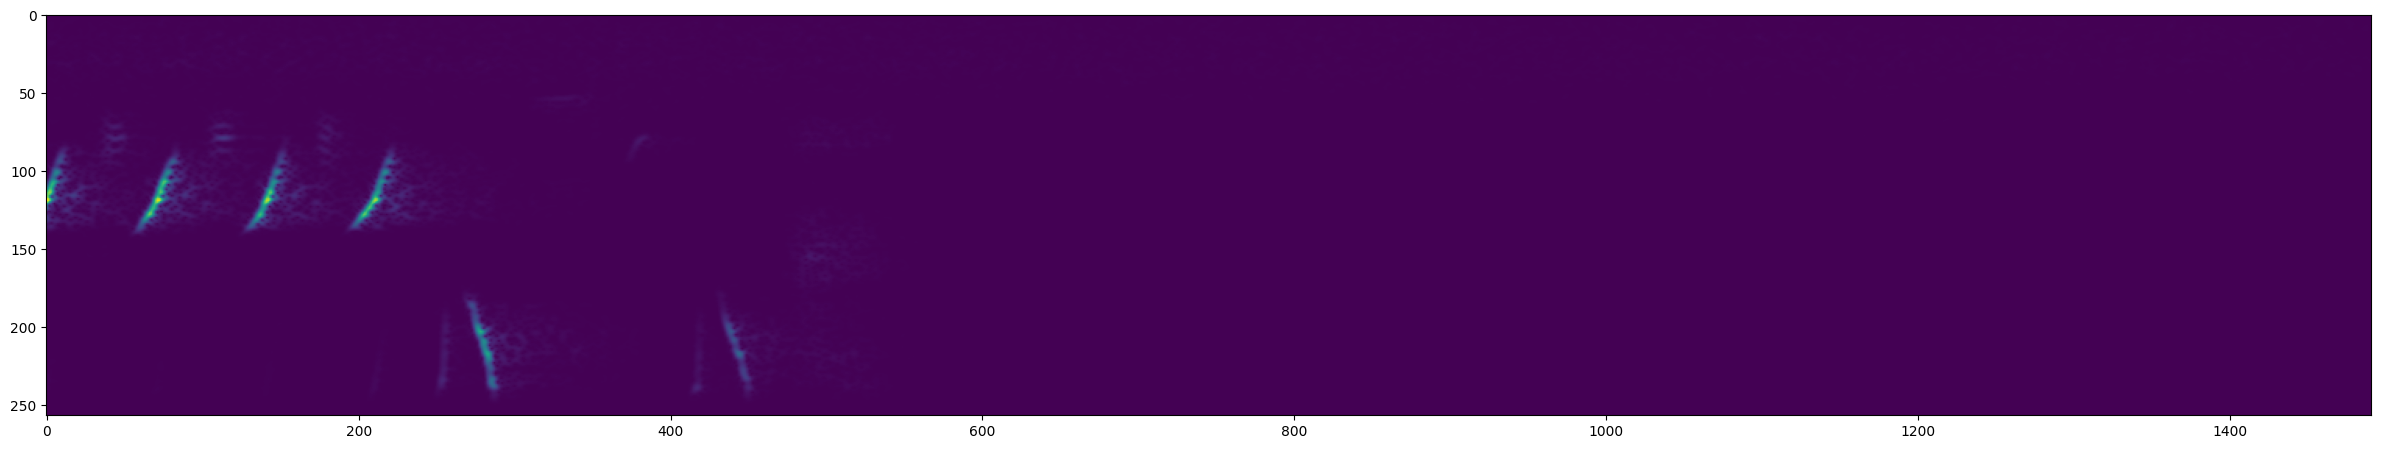

In [15]:
filepath, label = temp
spectrogram, label = spectogram_old(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

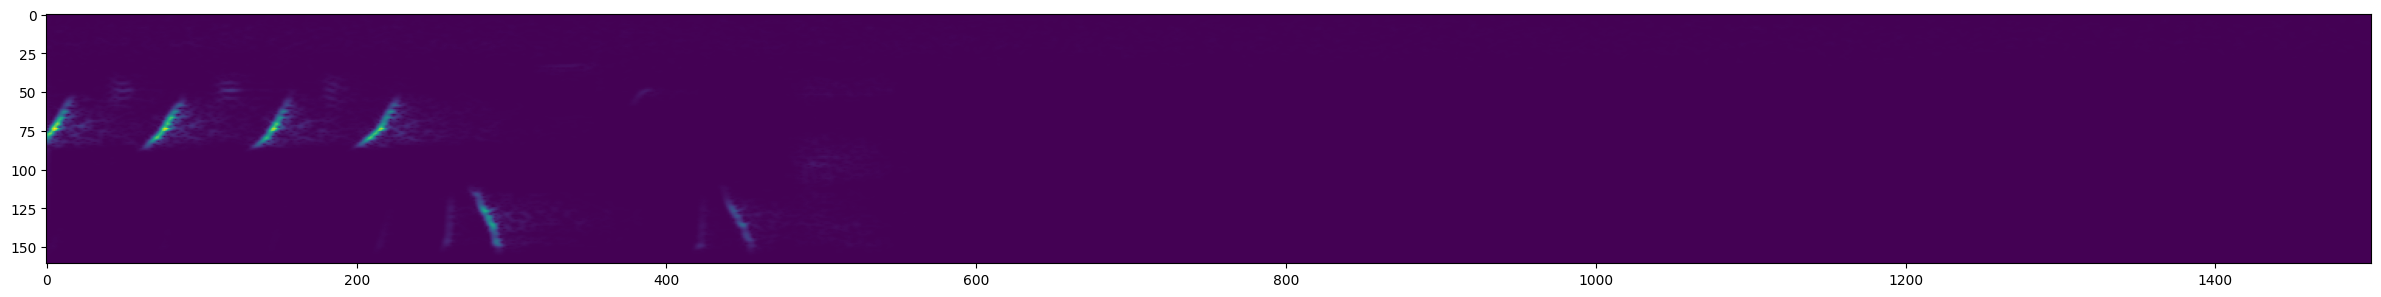

In [16]:
# Close enough
filepath, label = temp
spectrogram, label = spectogram(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Creating data subsets

In [17]:
# Mapping and batching data
data = data.map(spectogram)
data = data.cache()
data = data.shuffle(buffer_size=6000)
data = data.batch(16)
data = data.prefetch(8)

In [18]:
len(data)

339

In [19]:
# Dividing data to subsets
print(f'Train: {339 * 0.7}') #237
print(f'Val: {339 * 0.2}')   #68
print(f'Test: {339 * 0.1}')  #34

Train: 237.29999999999998
Val: 67.8
Test: 33.9


In [20]:
train = data.take(237)
test = data.skip(237).take(68)
val = data.skip(237+68).take(34)

In [21]:
samples, labels = val.as_numpy_iterator().next()

In [22]:
# Checking input shape
samples.shape

(16, 1501, 161, 1)

# Building and training model

In [23]:
# Building model - reshape instead of flatten is somehow needed
model = Sequential()
model.add(Input(shape=(1501, 161, 1)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Reshape((-1,)))  
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1501, 161, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 375, 40, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 375, 40, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 93, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       952,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954,929 (3.64 MB)

 Trainable params: 954,929 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.5426 - precision: 0.5543 - recall: 0.5034 - val_loss: 0.2247 - val_precision: 0.8496 - val_recall: 0.8129
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.2443 - precision: 0.7656 - recall: 0.7979 - val_loss: 0.1743 - val_precision: 0.8842 - val_recall: 0.7568
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - loss: 0.1860 - precision: 0.8210 - recall: 0.8218 - val_loss: 0.1323 - val_precision: 0.9153 - val_recall: 0.8780
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.1196 - precision: 0.9016 - recall: 0.9043 - val_loss: 0.0566 - val_precision: 0.8960 - val_recall: 0.9912
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - loss: 0.0699 - precision: 0.9405 - recall: 0.9612 - val_loss: 0.0346 - val_precision: 0.9756 - val_recall: 0.9836
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - loss: 0.0544 - precision: 0.9651 - recall: 0.9610 - val_loss: 0.0297 - val_precision: 0.9712 -

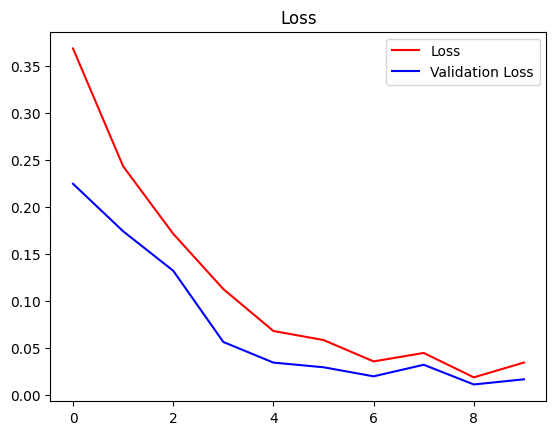

In [27]:
# Plotting loss 
plt.title('Loss')
plt.plot(hist.history['loss'], 'r', label='Loss')
plt.plot(hist.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

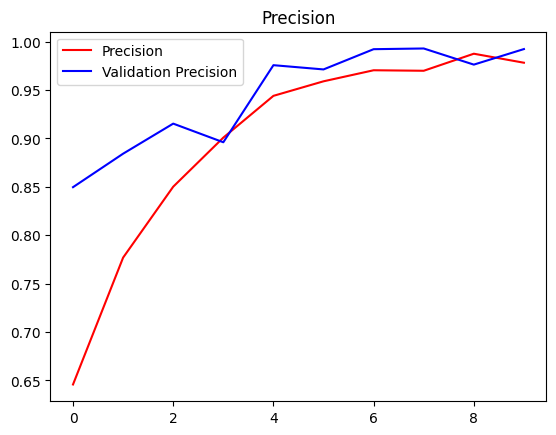

In [29]:
# Plotting precision 
plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label = 'Precision')
plt.plot(hist.history['val_precision'], 'b', label = 'Validation Precision')
plt.legend()
plt.show()

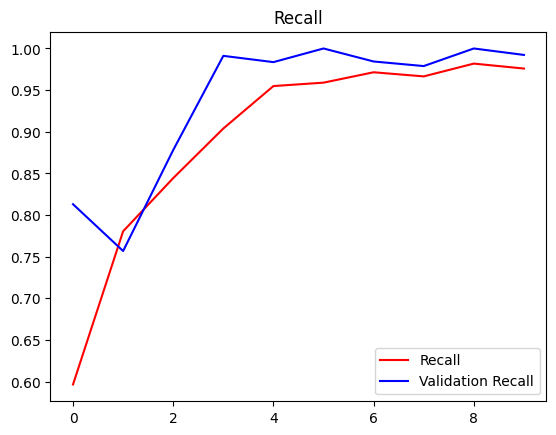

In [30]:
# Plotting recall
plt.title('Recall')
plt.plot(hist.history['recall'], 'r', label = 'Recall')
plt.plot(hist.history['val_recall'], 'b', label = 'Validation Recall')
plt.legend()
plt.show()

# Testing model 

In [177]:
X_test, y_test = test.as_numpy_iterator().next()

In [178]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [179]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [180]:
yhat

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [181]:
y_test

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [32]:
false_positives = 0
true_positives = 0
false_negatives = 0
true_negatives = 0
for test_case in test.as_numpy_iterator():
    X = test_case[0]
    y = test_case[1]
    y_hat = model.predict(X)
    y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

    for i in range(len(y_hat)):
        if y[i] == 0:
            if y_hat[i] == 0: true_negatives+=1
            else: false_positives+=1
        if y[i] == 1:
            if y_hat[i] == 0: false_negatives+=1
            else: true_positives+=1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [33]:
print(f"False positives: {false_positives}")
print(f"True positives: {true_positives}")
print(f"False negatives: {false_negatives}")
print(f"True negatives: {true_negatives}")

False positives: 2
True positives: 257
False negatives: 1
True negatives: 828


# Saving the model

In [36]:
from keras.models import load_model

model.save('sparrow_detect.h5')
